# Regularization for linear regression

## Goal

The goal of this lab is to explore the effect of regularization on linear regression for a toy dataset downloaded from Kaggle (the machine learning competition site).

## Get Ames data set and set up

Log into Kaggle and get [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). A useful discussion on this data set is [here](https://nycdatascience.com/blog/student-works/machine-learning-project/).

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.datasets import load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

## Load, extract columns without missing values, one-hot encode categoricals

In [2]:
df_ames = pd.read_csv("ames.csv")
df_ames.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
# ignore columns with missing values for this exercise
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]
X = X.drop('SalePrice', axis=1)
y = df_ames['SalePrice']

X = pd.get_dummies(X) # dummy encode categorical variables
X.shape

(1460, 216)

**1. Split off validation/test set and train unregularized linear regression model**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**2. Compare the R^2 on training and test set**

The model will not generalize at all and so the test set R^2 should be terrible (highly negative).

In [6]:
print(f"{lm.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lm.score(X_test, y_test):.2f} R^2 on test set")

0.92 R^2 on training set
0.88 R^2 on test set


**3. Predict $\overline{y}$ computed from training set instead of using the model; what is the R^2? on test set?**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.

In [7]:
y_pred = np.full(shape=(len(y_test),1), fill_value=np.mean(y_train))
r2_score(y_pred, y_test)

0.0

**4. Extract $\beta_0, ..., \beta_p$**

In [8]:
#beta = np.hstack([lm.intercept_, lm.coef_])
lm_beta = lm.coef_

In [9]:
sum(np.abs(lm_beta) < 1e-5) # how many close to 0?

5

**5. Plot the coefficient index versus the value**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.  The coefficients should look something like the following images, depending on which training samples are chosen:

<img src="ames-ols.png" width="300"><img src="ames-ols-2.png" width="300">

In [95]:
def plotbeta(beta, which, yrange=(-20_000, 20_000),fontsize=12, xlabel=True, ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Regression coefficient $\\beta_i$ for $i \\geq 1$", fontsize=12)
    ax.set_ylabel("Regression coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.1f}, $\\sigma(\\beta)$={np.std(beta):.1f}", fontsize=fontsize)

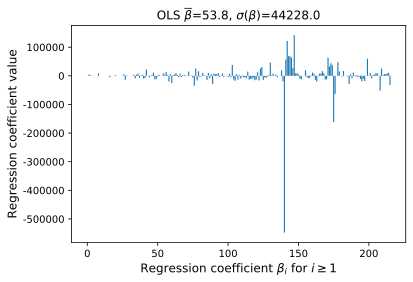

In [93]:
plotbeta(lm_beta, "OLS", yrange=None)
#plt.tight_layout(); plt.savefig("ames-ols.png",dpi=150,bbox_inches=0)

## Regularization

In [11]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

In [12]:
X_train = normalize(X_train)
X_test = normalize(X_test)

## L1 (Lasso) regularization

In [59]:
lmbda = 5

In [60]:
lasso = Lasso(alpha=lmbda, tol=.1)
lasso.fit(X_train, y_train)

Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.1, warm_start=False)

In [61]:
print(f"{lasso.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lasso.score(X_test, y_test):.2f} R^2 on test set")

0.90 R^2 on training set
0.87 R^2 on test set


In [62]:
lasso_beta = lasso.coef_
sum(np.abs(lasso_beta) < 1e-5) # how many close to 0?

9

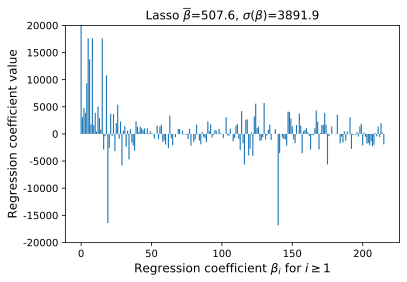

In [69]:
plotbeta(lasso_beta, "Lasso")

## L2 (Ridge) regularization

In [64]:
ridge = Ridge(alpha=lmbda)
ridge.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [65]:
print(f"{ridge.score(X_train, y_train):.2f} R^2 on training set")
print(f"{ridge.score(X_test, y_test):.2f} R^2 on test set")

0.92 R^2 on training set
0.89 R^2 on test set


In [66]:
sum(np.abs(ridge.coef_) < 1e-5) # how many close to 0?

5

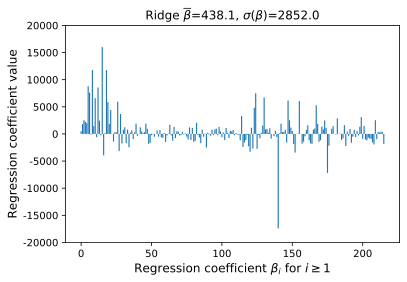

In [78]:
ridge_beta = ridge.coef_
plotbeta(ridge_beta, "Ridge")

## Effect of $\lambda$ on regularization

Number of beta close to zero lambda= 100: 54
Number of beta close to zero lambda= 200: 65
Number of beta close to zero lambda= 500: 111
Number of beta close to zero lambda=1000: 142


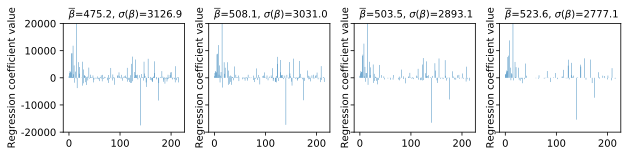

In [114]:
fig,axes = plt.subplots(1,4,figsize=(10,2), sharey=True)
for i,lmbda in enumerate([100,200,500,1000]):
    lasso = Lasso(alpha=lmbda)
    lasso.fit(X_train, y_train)
    print(f"Number of beta close to zero lambda={lmbda:4d}: {sum(np.abs(lasso.coef_) < 1e-5)}")
    plotbeta(lasso.coef_, "", ax=axes[i], fontsize=10, xlabel=False)

Number of beta close to zero at lambda= 100: 5
Number of beta close to zero at lambda= 200: 5
Number of beta close to zero at lambda= 500: 5
Number of beta close to zero at lambda=1000: 5


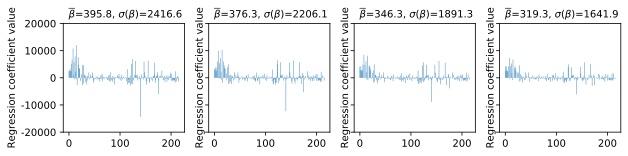

In [115]:
fig,axes = plt.subplots(1,4,figsize=(10,2), sharey=True)
for i,lmbda in enumerate([100,200,500,1000]):
    ridge = Ridge(alpha=lmbda)
    ridge.fit(X_train, y_train)
    print(f"Number of beta close to zero at lambda={lmbda:4d}: {sum(np.abs(ridge.coef_) < 1e-5)}")
    plotbeta(ridge.coef_, "", ax=axes[i], fontsize=10, xlabel=False)